In [44]:
import pandas as pd
import numpy as np
import pyodbc
import pandas.core.algorithms as algos
import getpass
from sklearn import metrics as met
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib
import datetime
import ipywidgets as widgets
import sys
sys.path.append('C:/YandexDisk/Work/RevoBigScorring/')
import scoringfunctions as sf
import woe
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7
pd.options.mode.chained_assignment = None

badFlag = 'badMob3'

import imp
sf = imp.reload(sf)
woe = imp.reload(woe)

df = pd.read_excel('20160511RevoQiwiRetrotest SCORING1205.xlsx')
df.to_csv('qiwiScore.csv',index=False)

In [12]:
connectString = 'DRIVER={SQL Server};SERVER=dwh.int.revoplus.ru;DATABASE=Revo_DW;UID=e.migaev;PWD='
pswd = getpass.getpass('DWH_Password: ')
connectString = connectString + pswd
cnxn = pyodbc.connect(connectString)
pswd = connectString = ''

DWH_Password: ········


## Data transform

In [13]:
df = pd.read_csv('qiwiScore.csv',encoding='cp1251')
bFlags = pd.read_csv('C:/YandexDisk/Work/Useful/BadFlags/badFlags.csv')

query = """select
	c.clientKey
	,cp.mobilePhone phone
from
	client	c
		left join
	ClientPhoneW cp
on
	c.ClientKey = cp.clientKey"""

clPhone = pd.read_sql(query,cnxn)

df.phone = df.phone.astype(float)
clPhone.phone = clPhone.phone.astype(float)
df = pd.merge(pd.merge(df,clPhone),bFlags,how='left')
df = df[~((df.badMob3.isnull())&(df.badFpd.isnull()))]
df.FromDate = pd.to_datetime(df.FromDate)
df.ToDate = pd.to_datetime(df.ToDate)
df.LastPayDate = pd.to_datetime(df.LastPayDate)
df.FirstPayDate_All = pd.to_datetime(df.FirstPayDate_All)
minDate = df.groupby('clientKey').min()['ToDate'].reset_index()
minDate['firstRow'] = 1
df = pd.merge(df,minDate,how='left',on = ['clientKey','ToDate'])
dfFirst = df[df['firstRow']==1]
dfFirst = dfFirst[dfFirst['badMob3'].notnull()]
dfFirst.to_csv('dfFirstSrc.csv',index=False)

In [211]:
maxDate = df.groupby('clientKey').max()['ToDate'].reset_index()
maxDate['lastRow'] = 1
df = pd.merge(df,maxDate,how='left',on = ['clientKey','ToDate'])
dfLast = df[df['lastRow']==1]
dfLast.to_csv('dfLastSrc.csv',index=False)

In [17]:
def more100func(x):
    if x>100:
        return 1
    else:
        return 0

In [14]:
numColumns = []
for col in dfFirst.columns:
    if dfFirst[col].dtype == np.float64 or dfFirst[col].dtype==np.int64:
        numColumns.append(col)
        
notNumColumns = list(set(dfFirst.columns).difference(set(numColumns)))

dfFirst['lastPayDiff'] = -(dfFirst.LastPayDate - dfFirst.ToDate).dt.days
dfFirst['FirstPayDate_AllDiff'] = -(dfFirst.FirstPayDate_All - dfFirst.ToDate).dt.days

dfFirst.loc[dfFirst['lastPayDiff']<0,'lastPayDiff'] = 0
dfFirst.loc[dfFirst['FirstPayDate_AllDiff']<0,'FirstPayDate_AllDiff'] = 0.0

maxCountProv = dfFirst.groupby('ProviderWithMaximumPaymentsCount').size().reset_index()
bigOperatorsMaxCount = list(maxCountProv.loc[maxCountProv[0]>2000,'ProviderWithMaximumPaymentsCount'])
dfFirst['maxCountProv'] = dfFirst.FirstPayDate_AllDiff.apply(lambda x: 1 if x in bigOperatorsMaxCount else 0)
dfFirst['maxSumProv'] = dfFirst.ProviderWithMaximumPaymentsSum.apply(lambda x: 1 if x in bigOperatorsMaxCount else 0)
dfFirst1 = dfFirst.drop(notNumColumns,axis=1)

dfFirst1['TotalMaxPayment'] = dfFirst1['TotalMaxPayment'].apply(more100func)
dfFirst1['MaxPayment6Month'] = dfFirst1['MaxPayment6Month'].apply(more100func)
dfFirst1['MaxPayment3Month'] = dfFirst1['MaxPayment3Month'].apply(more100func)
dfFirst1['MaxPayment1Month'] = dfFirst1['MaxPayment1Month'].apply(more100func)

dfFirst1.to_csv('dfFirst.csv',index=False)

In [21]:
dfFirst = pd.read_csv('dfFirst.csv',encoding='cp1251')

In [22]:
dfHit = dfFirst[dfFirst.TotalPaymentsSum>0]

In [23]:
dfPreClust = dfHit.copy()
dfPreClust = dfPreClust.drop(['phone','extra','clientKey','firstRow','badFpd'],axis = 1)
dfFirstPreWoe,clustInfo = sf.continuousVariables(dfPreClust,20)
dfFirstPostWoe, woeInfo = sf.woeVariables(dfFirstPreWoe,badFlag,minBadRateDiff=0)

Progress: 3.7%, 7.4%, 11.1%, 14.8%, 18.5%, 22.2%, 25.9%, 29.6%, 33.3%, 37.0%, 40.7%, 44.4%, 48.1%, 51.9%, 55.6%, 59.3%, 63.0%, 66.7%, 70.4%, 74.1%, 77.8%, 81.5%, 85.2%, 88.9%, 92.6%, 96.3%, 100.0%, 


## Variables graphics

C:\Users\e.migaev\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


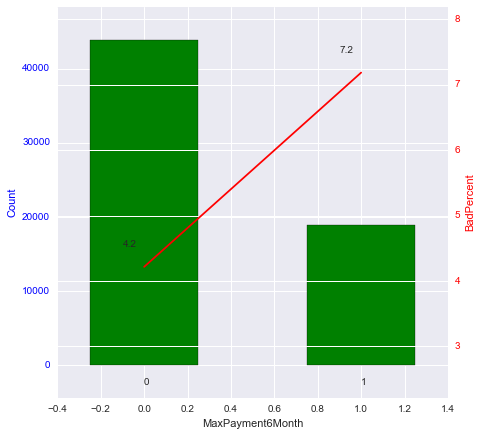

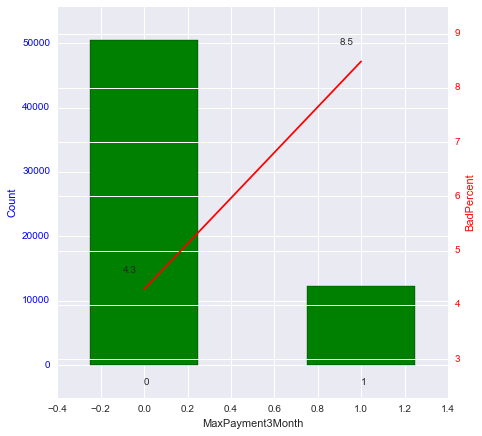

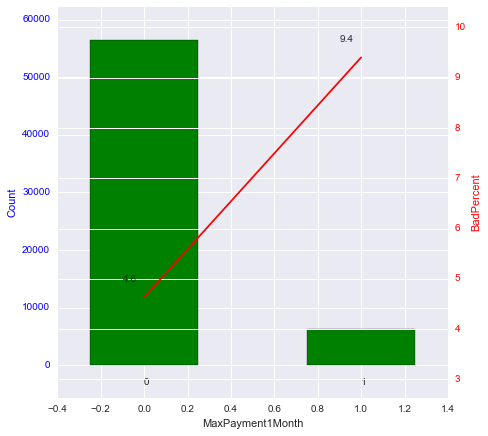

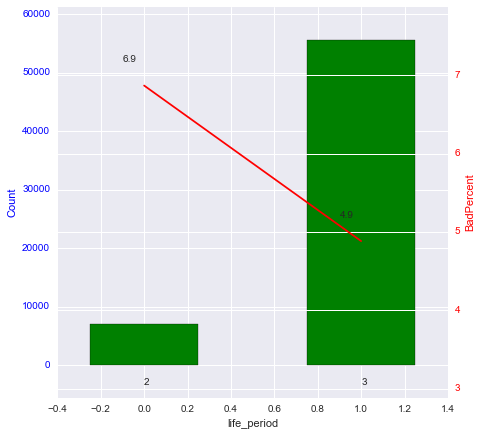

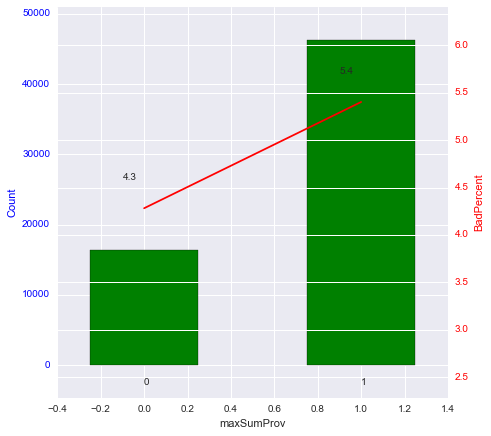

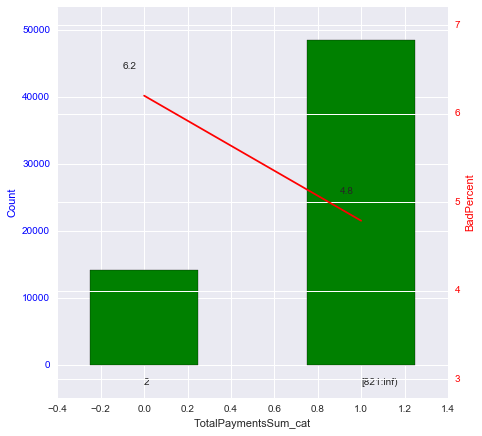

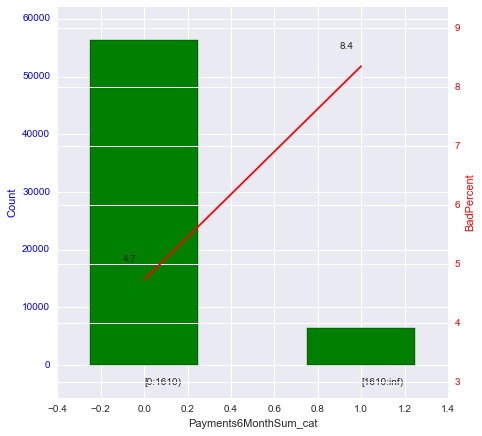

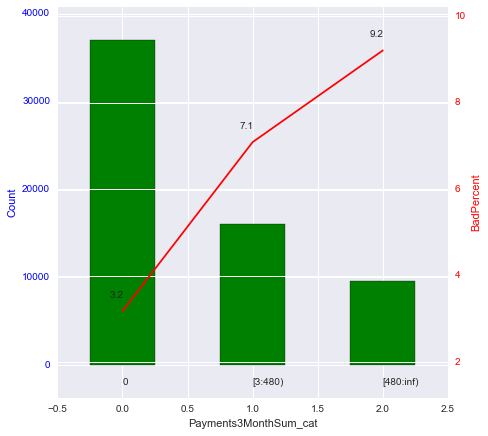

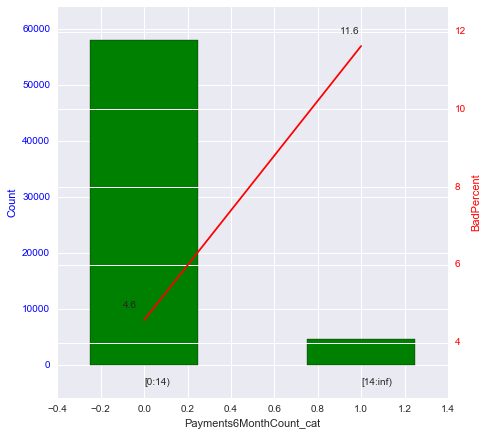

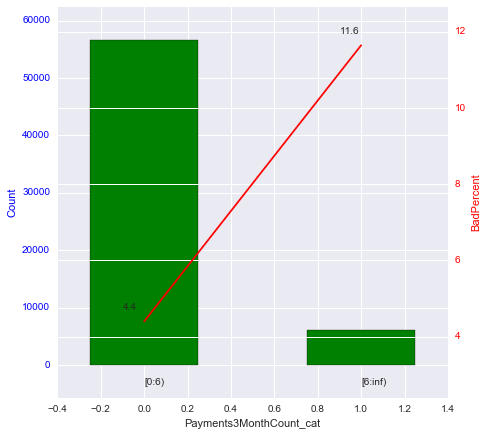

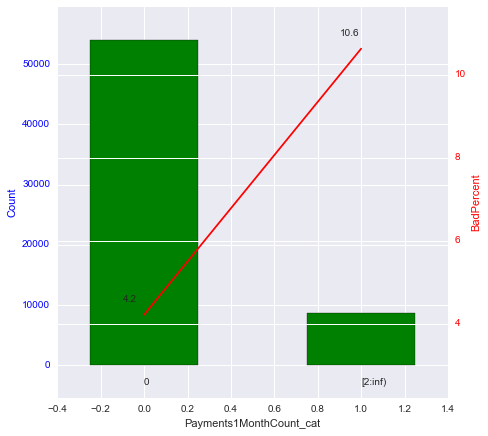

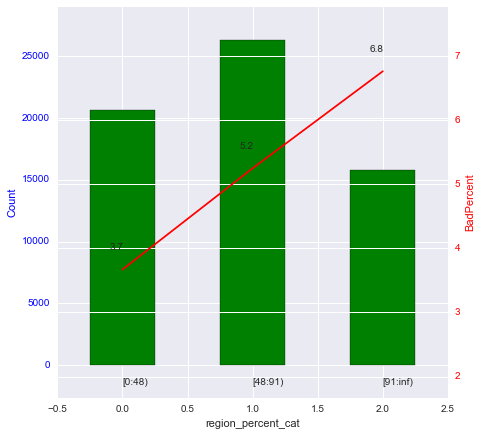

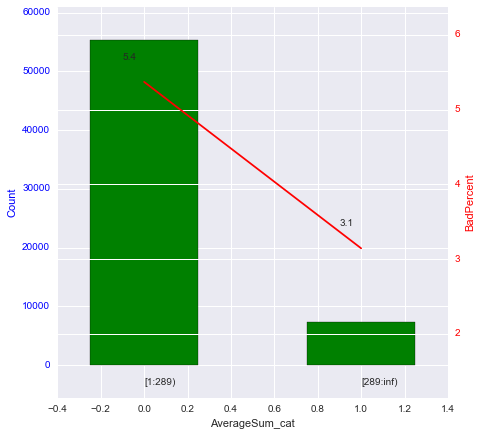

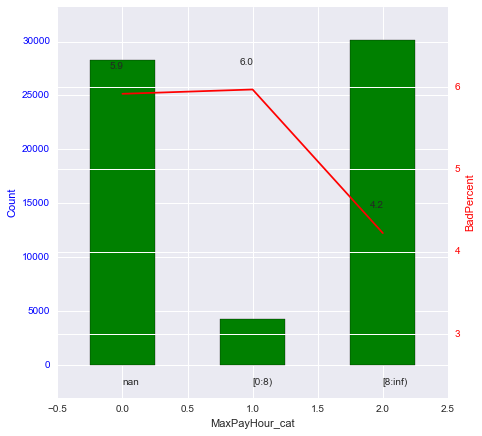

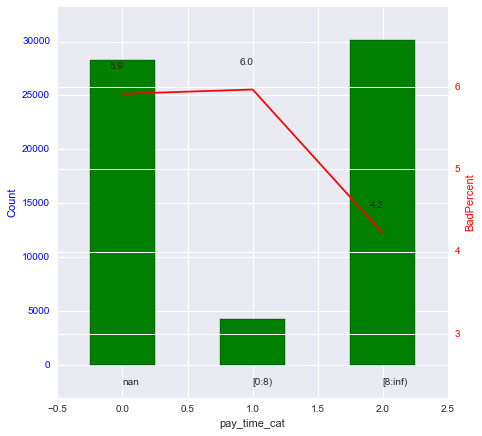

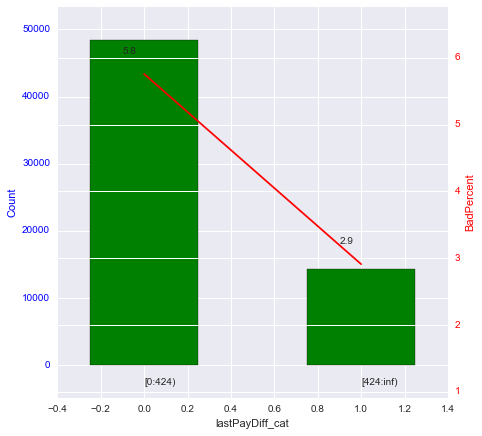

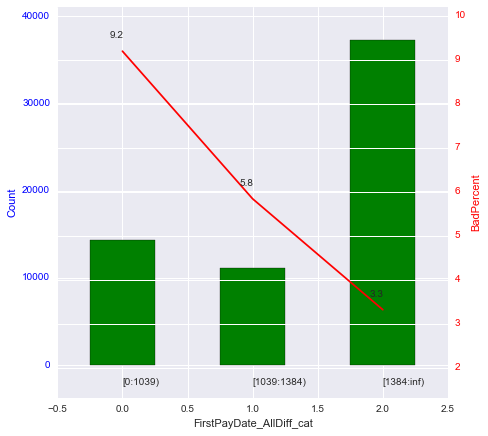

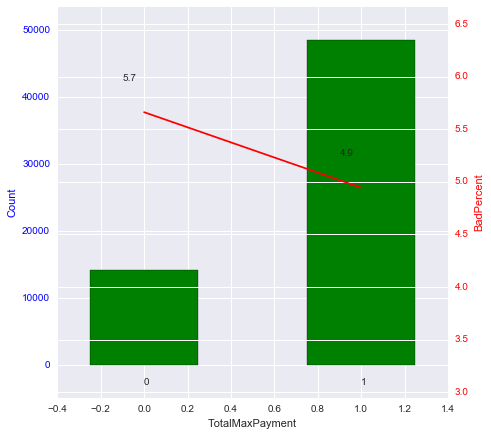

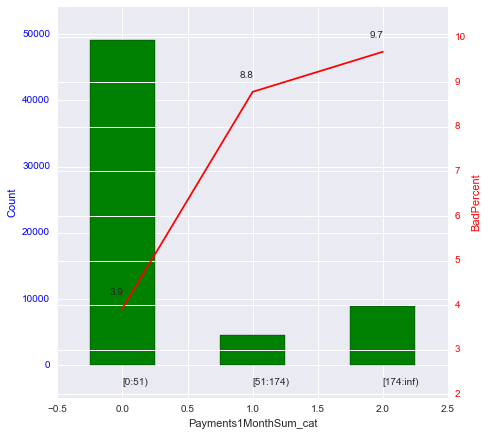

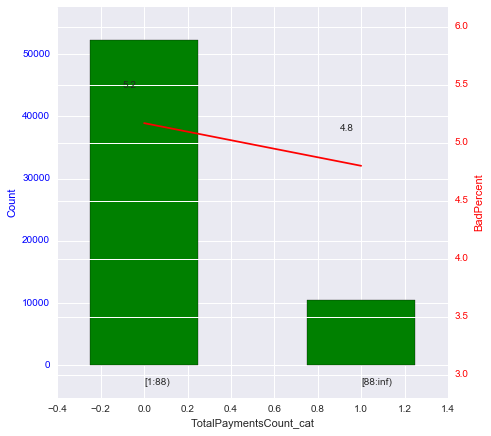

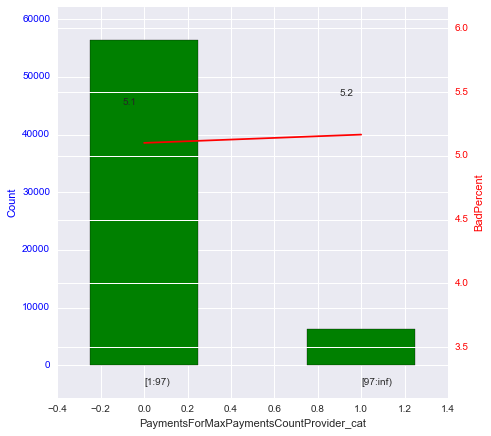

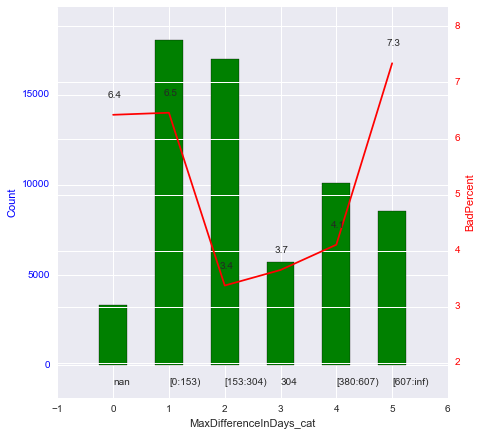

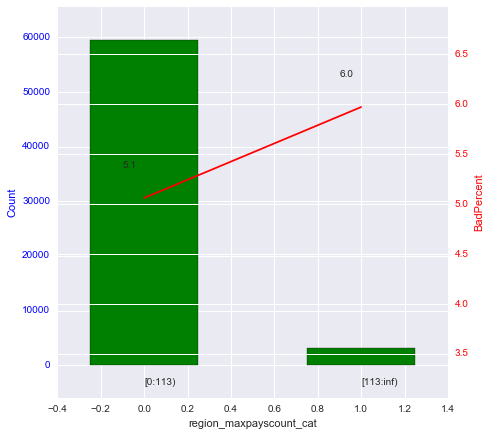

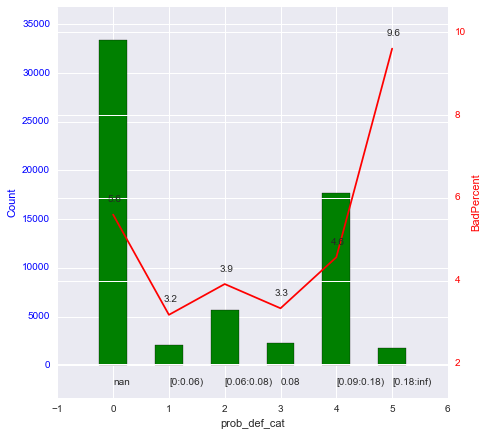

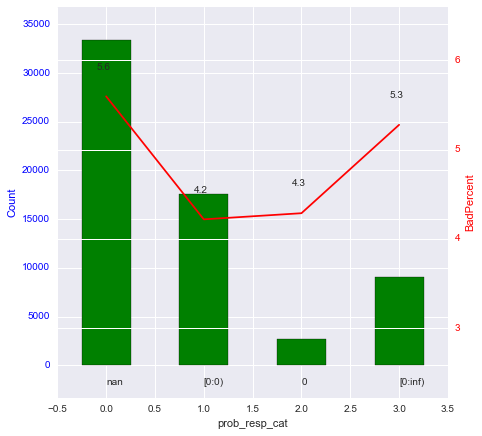

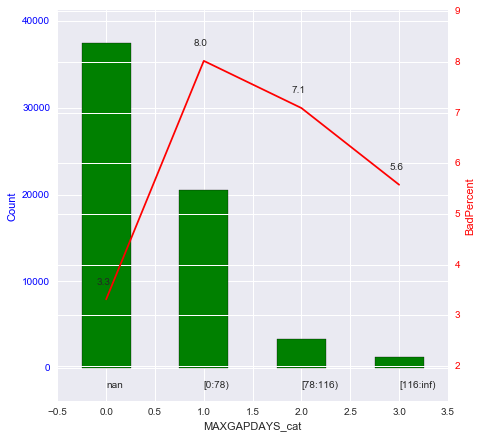

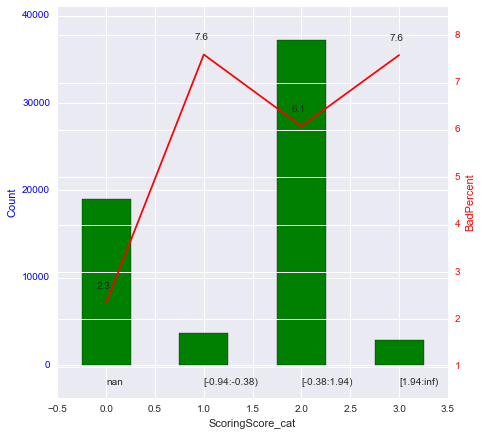

In [24]:
bc = woe.twinPlotWoe(woeInfo)

In [25]:
bc

['TotalMaxPayment',
 'Payments1MonthSum_cat',
 'TotalPaymentsCount_cat',
 'PaymentsForMaxPaymentsCountProvider_cat',
 'MaxDifferenceInDays_cat',
 'region_maxpayscount_cat',
 'prob_def_cat',
 'prob_resp_cat',
 'MAXGAPDAYS_cat',
 'ScoringScore_cat']

In [26]:
newPositions = { 'Payments1MonthSum_cat':[0,1],
                'MaxDifferenceInDays_cat':[0],
                'region_maxpayscount_cat':[0],
                'prob_def_cat':[0,1],
                'prob_resp_cat':[0,1,3],
                'MAXGAPDAYS_cat':[0,1,2],
                'ScoringScore_cat':[0,1]    
}

In [27]:
woeInfoTrans = woe.transformWoeVarsInfo(woeInfo,newPositions)
postWoeTransform = sf.getWOEcolumnAfterTransform(dfFirstPreWoe,woeInfoTrans)

In [28]:
postWoeTransform = postWoeTransform.drop(['maxCountProv'],axis=1)

## Variable Choose

### Information Value

In [29]:
informationTable = sf.giniGrowth(postWoeTransform, woeInfoTrans, badFlag)

In [30]:
informationTable

,variable,informationValue,testDiff,trainDiff,giniTest,giniTrain
8,Payments3MonthSum_cat_WOE,0.234432,2.570603e-01,2.491073e-01,0.257060,0.249107
19,FirstPayDate_AllDiff_cat_WOE,0.223977,1.093875e-01,1.036150e-01,0.366448,0.352722
25,MAXGAPDAYS_cat_WOE,0.201088,7.566939e-03,1.319325e-02,0.374015,0.365916
20,ScoringScore_cat_WOE,0.177461,1.365788e-02,9.329010e-03,0.387673,0.375245
22,Payments1MonthSum_cat_WOE,0.177308,4.809997e-03,2.617497e-03,0.392483,0.377862
12,Payments1MonthCount_cat_WOE,0.156806,1.051903e-03,2.524934e-03,0.393535,0.380387
11,Payments3MonthCount_cat_WOE,0.138709,2.199011e-03,3.679527e-03,0.395734,0.384067
10,Payments6MonthCount_cat_WOE,0.101919,1.128882e-03,-2.892497e-04,0.396862,0.383777
2,MaxPayment3Month_WOE,0.099240,8.559522e-05,2.648003e-04,0.396948,0.384042
18,lastPayDiff_cat_WOE,0.073625,3.500172e-03,9.158967e-04,0.400448,0.384958


In [50]:
goodColumns= list(informationTable[informationTable['testDiff']>0.002].variable.values) + [badFlag]
badCols = list(informationTable[informationTable['testDiff']<=0.002].variable.values)
#goodColumns = [x for x in goodColumns if x!='ScoringScore_cat_WOE']

preLR = dfFirstPostWoe[goodColumns]

In [51]:
for col in badCols:
    print (sf.preClean(col))

Payments1MonthCount
Payments6MonthCount
MaxPayment3Month
MaxPayment6Month
MaxPayment1Month
Payments6MonthSum
pay_time
AverageSum
prob_resp
life_period
TotalPaymentsSum
prob_def
maxSumProv
TotalMaxPayment
TotalPaymentsCount
PaymentsForMaxPaymentsCountProvider
MaxDifferenceInDays
region_maxpayscount


### Correlation

In [45]:
c1,c2 = sf.corrTable(preLR,informationTable)

In [46]:
c1

,var1,var2,r^2


In [47]:
c2

0

In [52]:
badCorColumns = []
goodColumns = [x for x in goodColumns if x not in badCorColumns]
preLR = dfFirstPostWoe[goodColumns]

In [53]:
for col in badCorColumns:
    print (sf.preClean(col))

## Model Built

In [54]:
for col in goodColumns:
    print (sf.preClean(col))

Payments3MonthSum
FirstPayDate_AllDiff
MAXGAPDAYS
ScoringScore
Payments1MonthSum
Payments3MonthCount
lastPayDiff
region_percent
MaxPayHour
badMob3


------------------------------------------------------------
train:


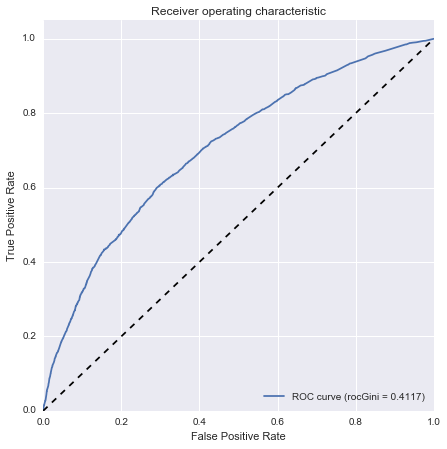

------------------------------------------------------------
test:


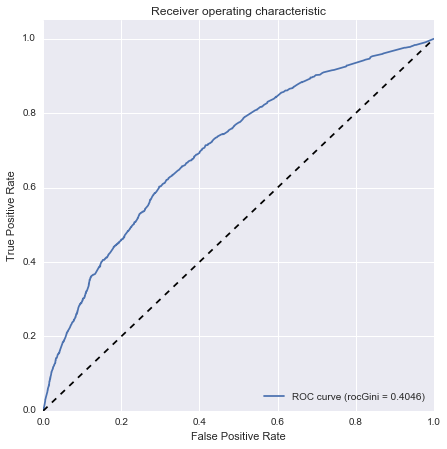

In [57]:
preLR = dfFirstPostWoe[goodColumns]

y = preLR[badFlag].values

preLRvar = preLR.drop(badFlag,axis=1)

X = preLRvar.values
clmn = list(preLRvar.columns)
fi = sf.featureImportance(X,y,clmn)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
lr = LogisticRegression(C=0.1)
lr.fit(X_train,y_train)
pr_test = lr.predict_proba(X_test)[:,1]
pr_train = lr.predict_proba(X_train)[:,1]

print('-'*60)
print("train:")
sf.rocCurve(y_train,pr_train)
print('-'*60)
print("test:")
sf.rocCurve(y_test,pr_test)


## Result Variables graphics

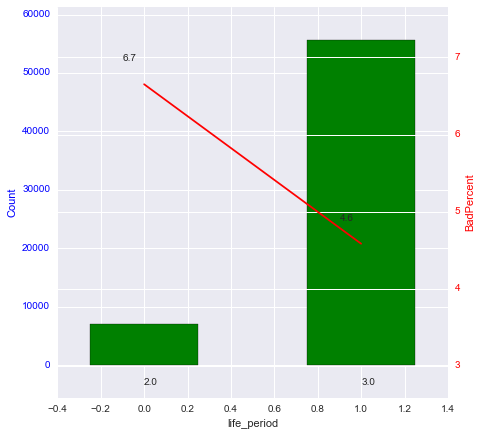

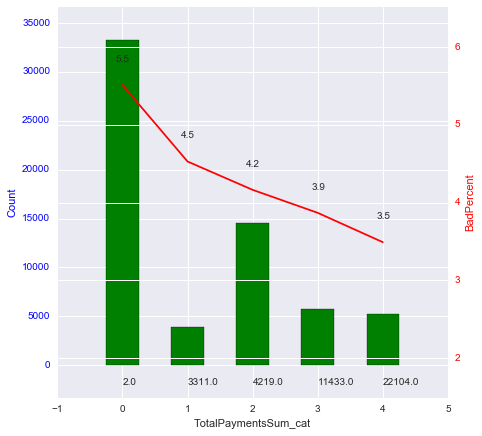

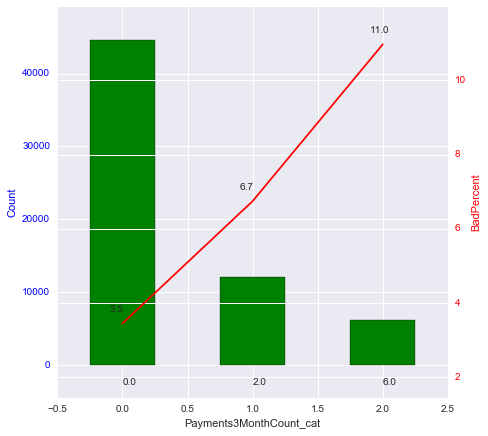

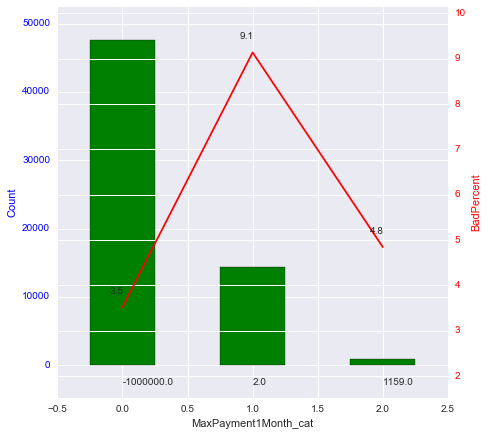

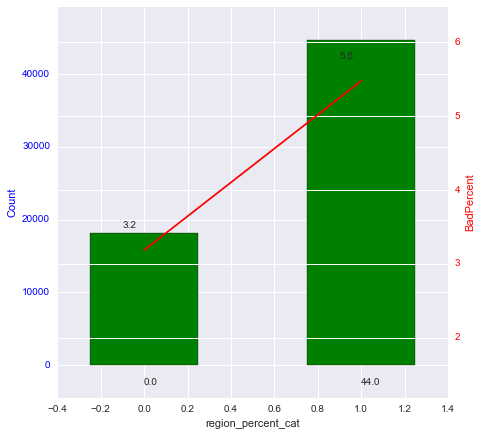

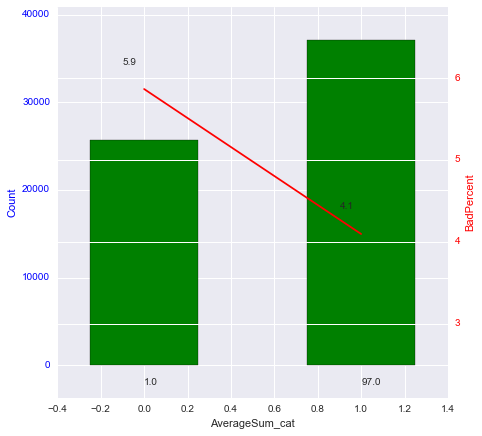

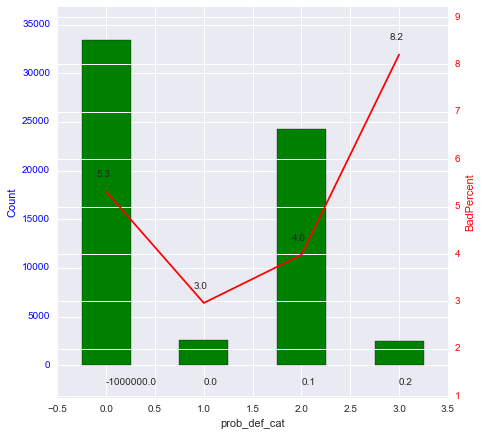

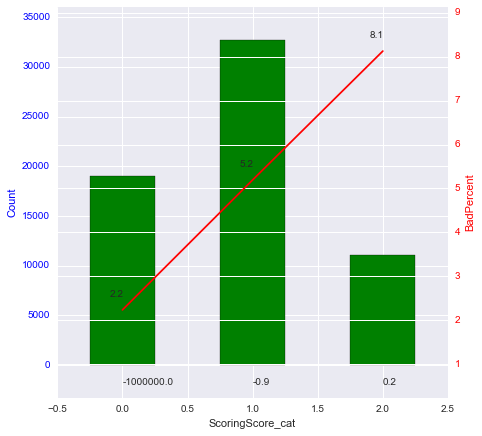

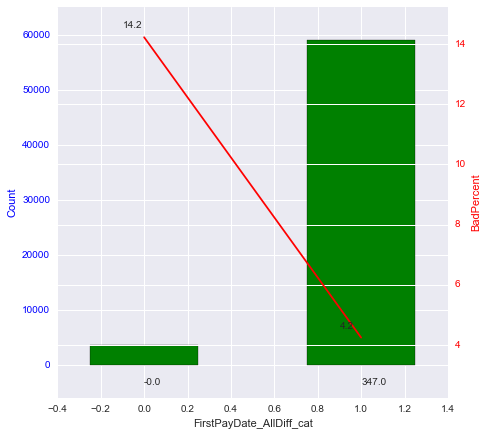

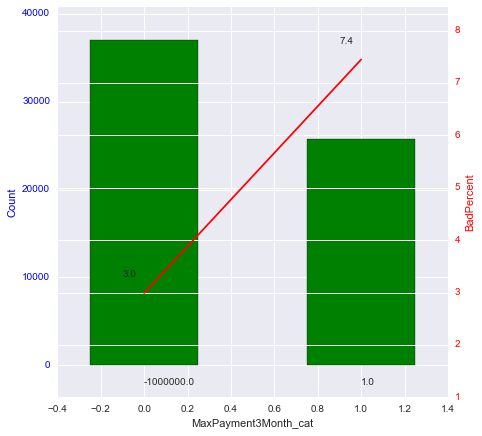

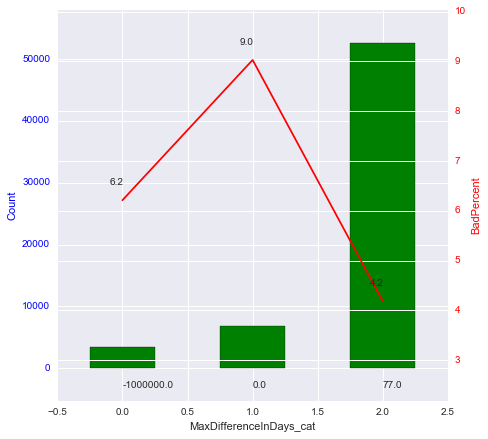

In [24]:
woe.twinPlotWoe(woeInfoTrans[woeInfoTrans.variable.isin([x[:-4] for x in goodColumns if x!=badFlag])])

## credit history dependency

------------------------------------------------------------
with CH:


C:\Users\e.migaev\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


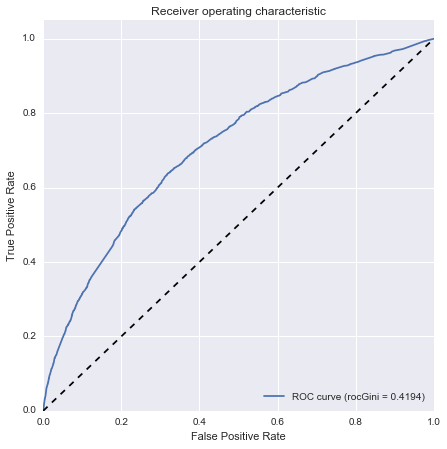

------------------------------------------------------------
without CH:


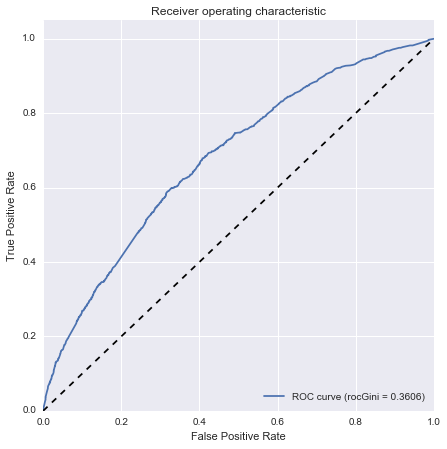

In [29]:
allClientsSample = pd.read_csv('C:/YandexDisk/Work/RevoBigScorring/sourceSmaple.csv',encoding='cp1251')

dfCl = pd.concat([dfFirst.clientKey.reset_index(drop=True),preLR.reset_index(drop=True)],axis=1)
dfClBur = pd.merge(dfCl,allClientsSample[['BkiFlg','clientKey']])

dfHist = dfClBur[dfClBur.BkiFlg==True]
dfNoHist = dfClBur[dfClBur.BkiFlg==False]

Xhist = dfHist.drop(['clientKey','BkiFlg','badMob3'],axis=1).values
yHist = dfHist.badMob3

XNohist = dfNoHist.drop(['clientKey','BkiFlg','badMob3'],axis=1).values
yNoHist = dfNoHist.badMob3

prHist = lr.predict_proba(Xhist)[:,1]
prNoHist = lr.predict_proba(XNohist)[:,1]

print('-'*60)
print("with CH:")
sf.rocCurve(yHist,prHist)
print('-'*60)
print("without CH:")
sf.rocCurve(yNoHist,prNoHist)

## hit

In [53]:
srcHist = dfFirst[dfFirst.clientKey.isin(dfHist.clientKey)]
srcWithoutHist = dfFirst[~dfFirst.clientKey.isin(dfHist.clientKey)]
srcHist[['clientKey'] + sf.columnClean(preLR.columns)].to_csv('qiwisrc.csv',index=False)
srcWithoutHist[['clientKey'] + sf.columnClean(preLR.columns)].to_csv('qiwisrcWOCH.csv',index=False)
clustInfo.to_csv('qiwiClustInfo.csv',index=False)
woeInfoTrans.to_csv('qiwiWoeInfo.csv',index=False)

In [3]:
allClientsSample = pd.read_csv('C:/YandexDisk/Work/RevoBigScorring/sourceSmaple.csv',encoding='cp1251')

C:\Users\e.migaev\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
a = pd.merge(dfFirst,allClientsSample[['clientKey','BkiFlg']])

In [10]:
a['hit'] = a.TotalPaymentsSum.apply(lambda x: 1 if x>0 else 0)

In [12]:
a.groupby(['BkiFlg','hit']).size().to_frame()

0
BkiFlg hit       
False  0     1097
       1    12581
True   0     3593
       1    50245